In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Truth Model
def a(t, w): # m/s^2
    return(10*np.sin(w*t))

def v(t, w, v_0): # m/s
    v = v_0 + (10/w)-(10/w)*np.cos(w*t)
    return(v)

def p(t, w, v_0, p_0):
    p = p_0 + (v_0 + (10/w))*t - (10/w**2)*np.sin(w*t)
    return(p)

# Accelerometer Model
def a_c(a, b, w):
    return(a + b + w)

def v_c(dt, v_c_0, a_c_0):
    return(v_c_0 + a_c_0 * dt)

def p_c(dt, p_c_0, v_c_0, a_c_0):
    return(p_c_0 + v_c_0*dt + a_c_0 * (dt**2)/2)

# Dynamic Model
# Same acceleration

def v_E(dt, v_E_0, a_0):
    return(v_E_0 + a_0 * dt)

def p_E(dt, p_E_0, v_E_0, a_0):
    return(p_E_0 + v_E_0*dt + a_0 * (dt**2)/2)





In [3]:
w = 0.2 # rad/s
sample_rate_acc = 200.0 # Hz
sample_rate_gps = 5.0 # Hz
dt_gps = 1.0/sample_rate_gps
dt_acc = 1.0/sample_rate_acc
num_samples = int(30*sample_rate_acc) + 1
num_samples_gps = int(30*sample_rate_gps) + 1
V = 0.0004 # (m/s^2)^2

M_b_0 = 0.01
b_a = np.random.normal(0, np.sqrt(M_b_0))
omega = np.random.normal(0, np.sqrt(V), num_samples)

p_mean_0 = 0.0
v_mean_0 = 100.0
M_p_0 = 100.0
M_v_0 = 1.0

v_0 = np.random.normal(v_mean_0, np.sqrt(M_v_0))
p_0 = np.random.normal(p_mean_0, np.sqrt(M_p_0))

V_k = np.array([[1, 0], [0, 0.04]])
gps_error = np.random.multivariate_normal(np.array([0, 0]).T, np.sqrt(V_k), num_samples_gps).T
# print(b_a)
# print(gps_error.shape)

t = np.arange(num_samples)*dt_acc
t_gps_idx = np.arange(num_samples)[0::40]
t_gps = t[t_gps_idx]
a_truth = a(t, w)
a_model = a_c(a_truth, b_a, omega)

x_model = np.zeros(num_samples)
v_model = np.zeros(num_samples)

x_model_true = np.zeros(num_samples)
v_model_true = np.zeros(num_samples)
for i in range(num_samples):
    if i == 0:
        x_model[i] = p_c(dt_acc, p_0, v_0, a_model[0])
        v_model[i] = v_c(dt_acc, v_0, a_model[0])
        x_model_true[i] = p_c(dt_acc, p_0, v_0, a_truth[0])
        v_model_true[i] = v_c(dt_acc, v_0, a_truth[0])
    else:
        x_model[i] = p_c(dt_acc, x_model[i-1], v_model[i-1], a_model[i-1])
        v_model[i] = v_c(dt_acc, v_model[i-1], a_model[i-1])
        x_model_true[i] = p_c(dt_acc, x_model_true[i-1], v_model[i-1], a_truth[i-1])
        v_model_true[i] = v_c(dt_acc, v_model_true[i-1], a_truth[i-1])

v_truth = v(t, w, v_0)
x_truth = p(t, w, v_0, p_0)

x_gps = x_truth[t_gps_idx]
v_gps = v_truth[t_gps_idx]
z = np.array([x_gps, v_gps])
z += gps_error

dz = z - np.array([x_model[t_gps_idx], v_model[t_gps_idx]])
dx_E = x_model_true - x_model
dv_E = v_model_true - v_model
print(dz.shape)

(2, 151)


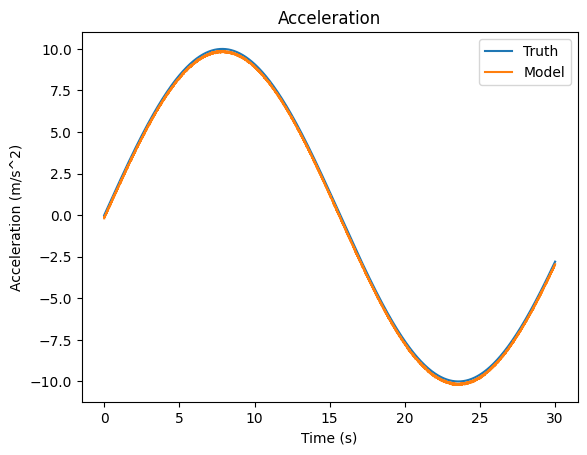

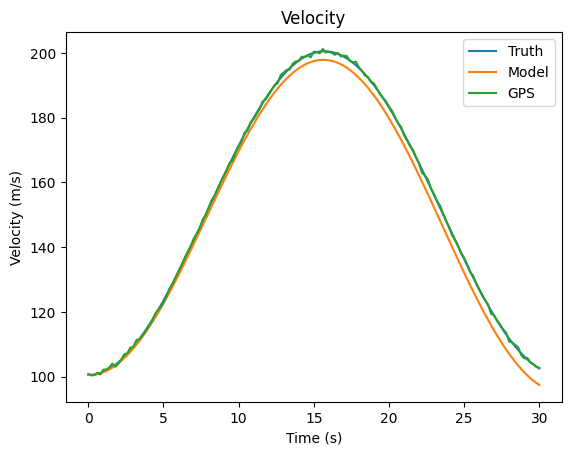

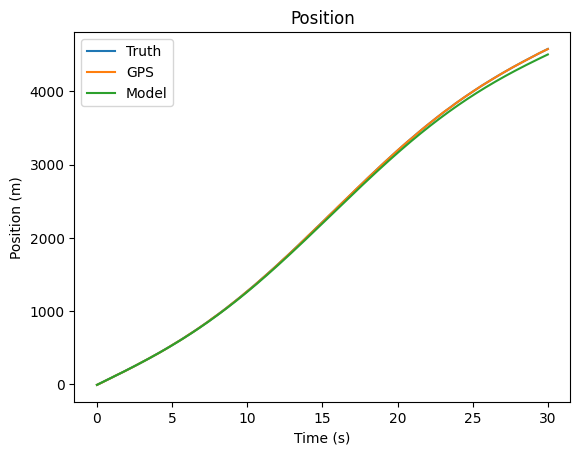

In [4]:
plt.figure()
plt.plot(t, a_truth, label='Truth')
plt.plot(t, a_model, label='Model')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.title("Acceleration")
# plt.savefig('Figures/Acceleration')
plt.show()

plt.figure()
plt.plot(t, v_truth, label='Truth')
plt.plot(t, v_model, label='Model')
plt.plot(t_gps, z[1], label='GPS')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("Velocity")
# plt.savefig('Figures/Velocity')
plt.show()

plt.figure()
plt.plot(t, x_truth, label='Truth')
plt.plot(t_gps, z[0], label='GPS')
plt.plot(t, x_model, label='Model')
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.title("Position")
plt.legend()
# plt.savefig('Figures/Position')
plt.show()



# Kalman Filter Equations

In [5]:

# Propagation of conditional mean (predicted a priori)
def x_bar_k1(phi_k, x_k_cond_mean_est):
    return(phi_k @ x_k_cond_mean_est)

# Covariance generated between measurements (predicted a priori)
def M_k1(phi_k, P_k, gamma_k, W_k):
    return(phi_k @ P_k @ phi_k.T + gamma_k * W_k @ gamma_k.T)

# Updating conditional mean (a posteriori)
def x_k_cond_mean_est(x_bar_k, M_k, H_k, V_k, z_k):
    residual = z_k - H_k @ x_bar_k
    # Kalman_gain = P_k @ H_k.T @ np.linalg.inv(V_k)
    Kalman_gain = M_k@H_k.T@np.linalg.inv(H_k@M_k@H_k.T + V_k)
    return (x_bar_k + Kalman_gain @ residual) , residual, Kalman_gain


# Updating covariance (a posteriori)
def P_k(M_k, H_k, V_k):
    # return(np.linalg.inv(np.linalg.inv(M_k) + H_k.T @ np.linalg.inv(V_k) @ H_k))
    return(M_k - M_k@H_k.T@np.linalg.inv(H_k@M_k@H_k.T+V_k)@H_k@M_k)

In [6]:
phi = np.array([[1, dt_acc, -(dt_acc**2)/2],
                [0, 1, -dt_acc],
                [0, 0, 1]])

gamma = np.array([[-(dt_acc**2)/2, -dt_acc, 0]]).T

W_cov = V

# z_k = H*x_k +v_k
# z_k: actual measurement of x at time k (GPS pos and vel)
# H: connection between state and measurement vector
# v_k: measurement error (defined above)
# x_k: state vector (pos, vel, acc)
H = np.array([[1, 0, 0],
              [0, 1, 0]])


M_k = np.array([[M_p_0, 0, 0],
                  [0, M_v_0, 0],
                  [0, 0, M_b_0]])

x_k_mean = np.array([np.random.normal(0, M_p_0), np.random.normal(0, M_v_0), np.random.normal(0, M_b_0)]).T
# x_k_mean = np.array([0, 100, 0])
# x_k_mean = np.array([p_0, v_0, b_a])
# x_k_mean = np.random.normal(0, np.sqrt(0.1), 3)
dx_estimate = np.array([0, 0, 0]).T
x_bar = np.zeros((num_samples, 3))
x_error = np.array((num_samples, 3))

P_history = np.zeros((num_samples_gps, 3, 3))

In [7]:
for i in range(num_samples):
    time = t[i]
    if not np.all(np.where(i == t_gps_idx, 0, 1)):
        j = int(i/40)
        dx_estimate, residual, gain = x_k_cond_mean_est(x_k_mean, M_k, H, V_k, dz[:, j])
        P = P_k(M_k, H, V_k)
        P_history[j] = P
        x_k_mean = x_bar_k1(phi, dx_estimate)
        M_k = M_k1(phi, P, gamma, W_cov)
        x_bar[i] = x_k_mean

    else:
        x_k_mean = x_bar_k1(phi, x_k_mean)
        M_k = M_k1(phi, M_k, gamma, W_cov)
        x_bar[i] = x_k_mean

x_bar = x_bar.T

In [8]:
x_est = x_bar[0] + x_model
v_est = x_bar[1] + v_model
bias_est = x_bar[2]

x_error = x_truth - x_est
v_error = v_truth - v_est
bias_error = b_a - bias_est

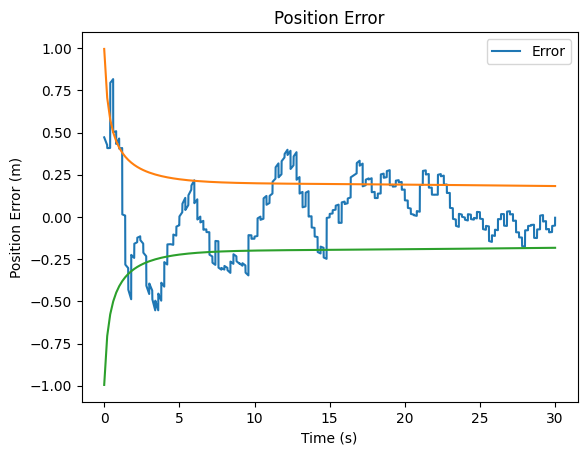

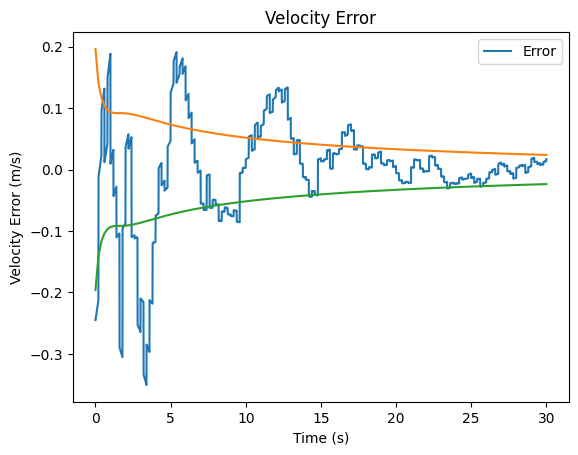

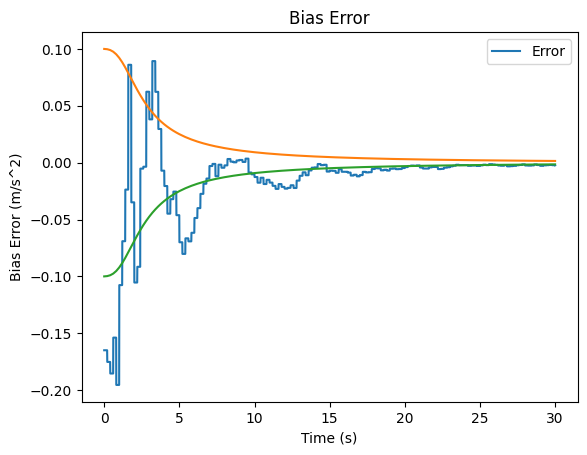

In [9]:
plt.figure()
plt.plot(t, x_error, label='Error')
plt.plot(t_gps, np.sqrt(P_history[:, 0, 0]))
plt.plot(t_gps, -np.sqrt(P_history[:, 0, 0]))
plt.xlabel("Time (s)")
plt.ylabel("Position Error (m)")
plt.title("Position Error")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, v_error, label='Error')
plt.plot(t_gps, np.sqrt(P_history[:, 1, 1]))
plt.plot(t_gps, -np.sqrt(P_history[:, 1, 1]))
plt.xlabel("Time (s)")
plt.ylabel("Velocity Error (m/s)")
plt.title("Velocity Error")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, bias_error, label='Error')
plt.plot(t_gps, np.sqrt(P_history[:, 2, 2]))
plt.plot(t_gps, -np.sqrt(P_history[:, 2, 2]))
plt.xlabel("Time (s)")
plt.ylabel("Bias Error (m/s^2)")
plt.title("Bias Error")
plt.legend()
plt.show()

In [10]:
N = 100
w = 0.2 # rad/s
sample_rate_acc = 200.0 # Hz
sample_rate_gps = 5.0 # Hz
dt_gps = 1.0/sample_rate_gps
dt_acc = 1.0/sample_rate_acc
num_samples = int(30*sample_rate_acc) + 1
num_samples_gps = int(30*sample_rate_gps) + 1
V = 0.0004 # (m/s^2)^2

p_mean_0 = 0.0
v_mean_0 = 100.0
M_p_0 = 10.0
M_v_0 = 1.0

M_b_0 = 0.01

V_k = np.array([[1, 0], [0, 0.04]])
t = np.arange(num_samples)*dt_acc
t_gps_idx = np.arange(num_samples)[0::40]
t_gps = t[t_gps_idx]

a_truth = a(t, w)

error_realization = np.zeros((N, 3, num_samples))
x_bar_hist = np.zeros((N, 3, num_samples))
residual_avg = np.zeros((N, num_samples_gps, 2, 2))
P_history = np.zeros((N, num_samples_gps, 3, 3))

for k in range(N):

    b_a = np.random.normal(0, np.sqrt(M_b_0))
    omega = np.random.normal(0, np.sqrt(V), num_samples)

    v_0 = np.random.normal(v_mean_0, np.sqrt(M_v_0))
    p_0 = np.random.normal(p_mean_0, np.sqrt(M_p_0))

    gps_error = np.random.multivariate_normal(np.array([0, 0]).T, np.sqrt(V_k), num_samples_gps).T

    a_model = a_c(a_truth, b_a, omega)

    x_model = np.zeros(num_samples)
    v_model = np.zeros(num_samples)

    x_model_true = np.zeros(num_samples)
    v_model_true = np.zeros(num_samples)
    for i in range(num_samples):
        if i == 0:
            x_model[i] = p_c(dt_acc, p_0, v_0, a_model[0])
            v_model[i] = v_c(dt_acc, v_0, a_model[0])
            x_model_true[i] = p_c(dt_acc, p_0, v_0, a_truth[0])
            v_model_true[i] = v_c(dt_acc, v_0, a_truth[0])
        else:
            x_model[i] = p_c(dt_acc, x_model[i-1], v_model[i-1], a_model[i-1])
            v_model[i] = v_c(dt_acc, v_model[i-1], a_model[i-1])
            x_model_true[i] = p_c(dt_acc, x_model_true[i-1], v_model[i-1], a_truth[i-1])
            v_model_true[i] = v_c(dt_acc, v_model_true[i-1], a_truth[i-1])

    v_truth = v(t, w, v_0)
    x_truth = p(t, w, v_0, p_0)

    x_gps = x_truth[t_gps_idx]
    v_gps = v_truth[t_gps_idx]
    z = np.array([x_gps, v_gps])
    z += gps_error

    dz = z - np.array([x_model[t_gps_idx], v_model[t_gps_idx]])
    dx_E = x_model_true - x_model
    dv_E = v_model_true - v_model

    phi = np.array([[1, dt_acc, -dt_acc**2/2],
                [0, 1, -dt_acc],
                [0, 0, 1]])

    gamma = np.array([[dt_acc**2/2, dt_acc, 0]]).T

    W_cov = V

    # z_k = H*x_k +v_k
    # z_k: actual measurement of x at time k (GPS pos and vel)
    # H: connection between state and measurement vector
    # v_k: measurement error (defined above)
    # x_k: state vector (pos, vel, acc)
    H = np.array([[1, 0, 0],
                [0, 1, 0]])


    M_k = np.array([[M_p_0, 0, 0],
                    [0, M_v_0, 0],
                    [0, 0, M_b_0]])

    x_k_mean = np.array([np.random.normal(0, M_p_0), np.random.normal(0, M_v_0), np.random.normal(0, M_b_0)]).T
    # x_k_mean = np.array([0, 0, 0])
    dx_estimate = np.array([0, 0, 0]).T
    x_bar = np.zeros((num_samples, 3))
    x_error = np.array((num_samples, 3))


    for i in range(num_samples):
        time = t[i]
        if not np.all(np.where(i == t_gps_idx, 0, 1)):
            j = int(i/40)
            dx_estimate, residual, gain = x_k_cond_mean_est(x_k_mean, M_k, H, V_k, dz[:, j])
            residual_avg[k, j] = residual
            P = P_k(M_k, H, V_k)
            P_history[k, j] = P
            x_k_mean = x_bar_k1(phi, dx_estimate)
            M_k = M_k1(phi, P, gamma, W_cov)
            x_bar[i] = x_k_mean

        else:
            x_k_mean = x_bar_k1(phi, x_k_mean)
            M_k = M_k1(phi, M_k, gamma, W_cov)
            x_bar[i] = x_k_mean
    
    x_bar = x_bar.T

    x_est = x_bar[0] + x_model
    v_est = x_bar[1] + v_model
    bias_est = x_bar[2]
    x_bar_hist[k] = np.array([x_est, v_est, bias_est])

    x_error = x_truth - x_est
    v_error = v_truth - v_est
    bias_error = b_a - bias_est

    error_realization[k] = np.array([x_error, v_error, bias_error])



(3, 6001)


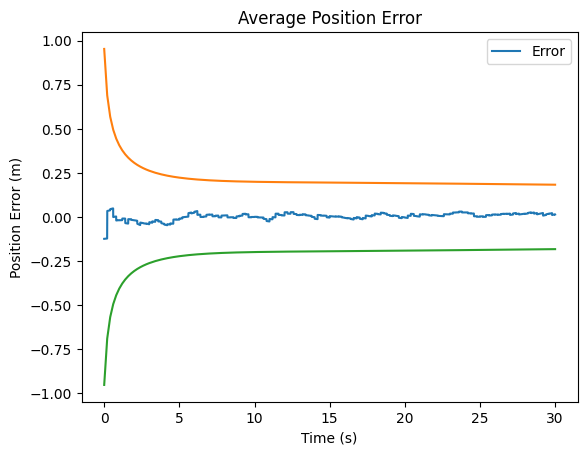

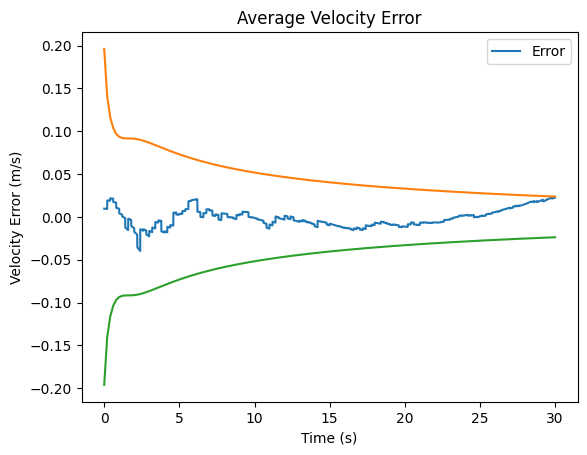

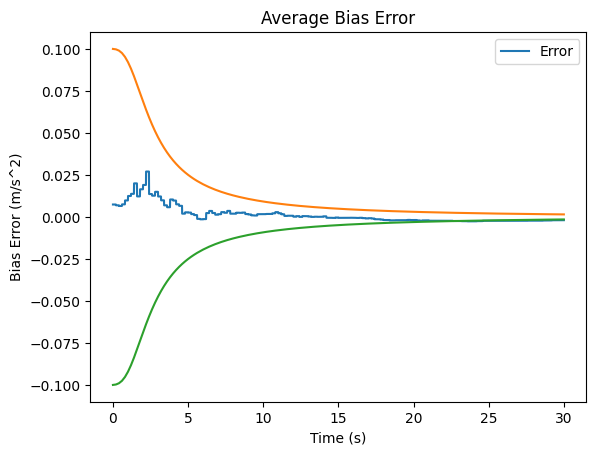

In [11]:
error_avg = np.mean(error_realization, axis=0)

print(error_avg.shape)
plt.figure()
plt.plot(t, error_avg[0], label='Error')
plt.plot(t_gps, np.sqrt(P_history[-1, :, 0, 0]))
plt.plot(t_gps, -np.sqrt(P_history[-1, :, 0, 0]))
plt.xlabel("Time (s)")
plt.ylabel("Position Error (m)")
plt.title("Average Position Error")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, error_avg[1], label='Error')
plt.plot(t_gps, np.sqrt(P_history[-1, :, 1, 1]))
plt.plot(t_gps, -np.sqrt(P_history[-1, :, 1, 1]))
plt.xlabel("Time (s)")
plt.ylabel("Velocity Error (m/s)")
plt.title("Average Velocity Error")
plt.legend()
plt.show()

plt.figure()
plt.plot(t, error_avg[2], label='Error')
plt.plot(t_gps, np.sqrt(P_history[-1, :, 2, 2]))
plt.plot(t_gps, -np.sqrt(P_history[-1, :, 2, 2]))
plt.xlabel("Time (s)")
plt.ylabel("Bias Error (m/s^2)")
plt.title("Average Bias Error")
plt.legend()
plt.show()

(6001, 3, 3)


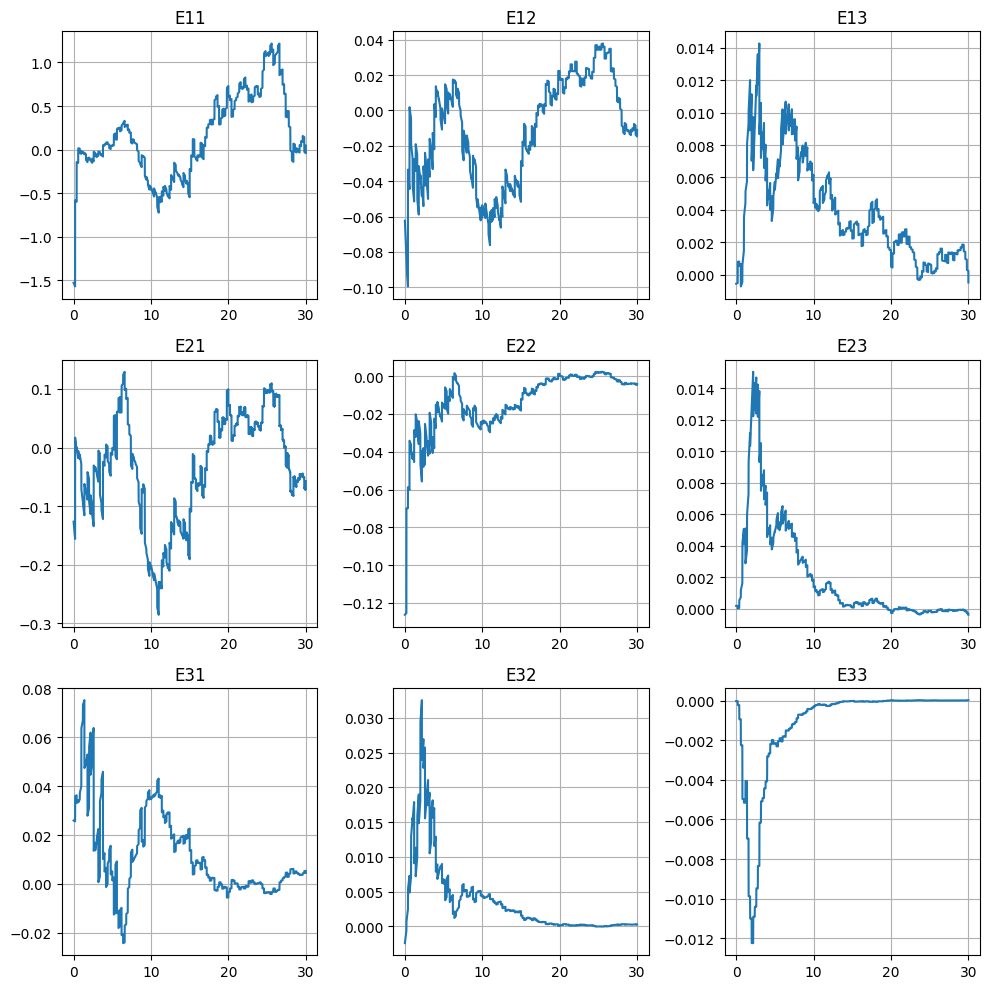

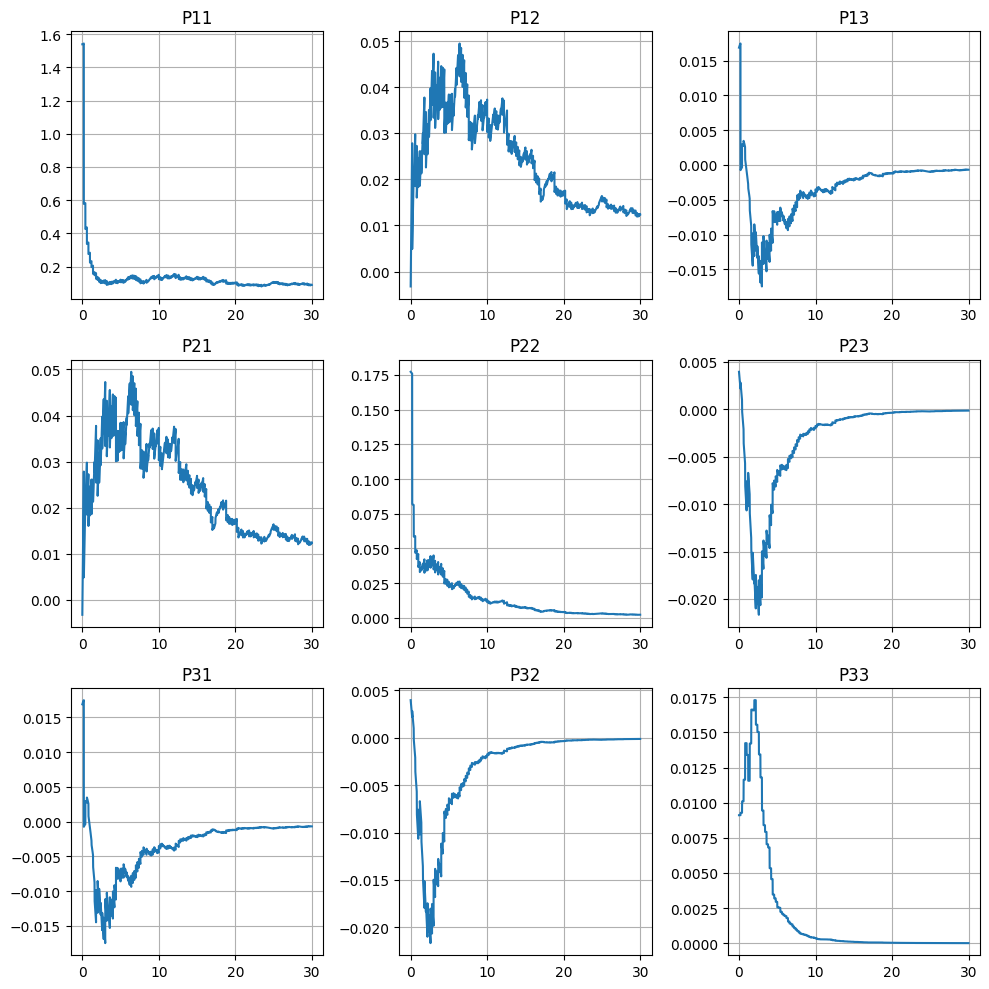

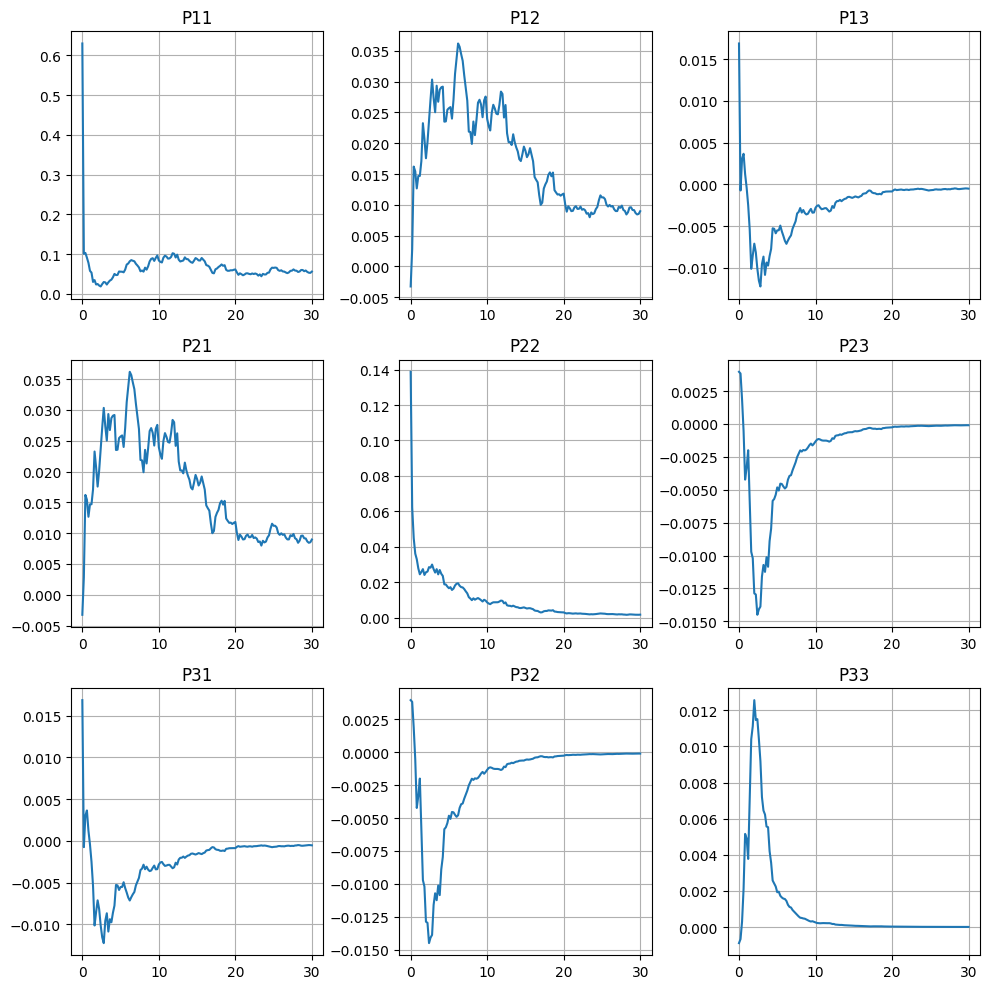

In [12]:
# Orthogonality
a = np.zeros((num_samples, 3, 3))
for i in range(N):
    for j in range(num_samples):
        a[j] += ((error_realization[i, :, j] - error_avg[:, j])).reshape(3, 1)@(x_bar_hist[i, :, j]).reshape(1, 3)

a /= N
print(a.shape)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for k in range(3):
    for j in range(3):
        ax[k, j].plot(t, a[:, k, j])
        ax[k, j].set_title(f"E{k+1}{j+1}")
        ax[k, j].grid(True)
plt.tight_layout()
plt.show()


# Covariance
P_avg = np.zeros((num_samples, 3, 3))
for i in range(N):
    for j in range(num_samples):
        P_avg[j] += (error_realization[i, :, j] - error_avg[:, j]).reshape(3, 1)@(error_realization[i, :, j] - error_avg[:, j]).reshape(1,3)

P_final = P_avg/(N-1)

# print(P_final.shape)

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for k in range(3):
    for j in range(3): 
        ax[k, j].plot(t, P_final[:, k, j])
        ax[k, j].set_title(f"P{k+1}{j+1}")
        ax[k, j].grid(True)
plt.tight_layout()
plt.show()


P_diff = np.mean(P_final[t_gps_idx] - P_history, axis=0)
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for k in range(3):
    for j in range(3): 
        ax[k, j].plot(t_gps, P_diff[:, k, j])
        ax[k, j].set_title(f"P{k+1}{j+1}")
        ax[k, j].grid(True)
plt.tight_layout()
plt.show()

In [13]:
# Residual check
print(residual_avg.shape)

d = np.zeros((2, 2))
for i in range(N):
    for j in range(num_samples_gps - 1):
        d = residual_avg[i, -1]@residual_avg[i, j]
d /= (N)
print(d, np.linalg.norm(d))

(100, 151, 2, 2)
[[ 0.00481986 -0.00267533]
 [ 0.00481986 -0.00267533]] 0.007795948924649516
